In [26]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

In [27]:
# 데이터 로드
train = pd.read_csv("C:/coding/data_kuggle/dataset/train.csv")
test = pd.read_csv('C:/coding/data_kuggle/dataset/test.csv')
submission = pd.read_csv('C:/coding/data_kuggle/dataset/sample_submission.csv')

In [28]:
pd.options.display.float_format = '{:.2f}'.format 
plt.rcParams['font.family'] = 'Malgun Gothic'

## 데이터 확인

In [29]:
train.tail()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
6250,6251,45,31/08/2012,75.09,3.87,23641.30,6.00,92.93,6988.31,3992.13,8.68,False,734297.87
6251,6252,45,07/09/2012,75.70,3.91,11024.45,12.80,52.63,1854.77,2055.70,8.68,True,766512.66
6252,6253,45,14/09/2012,67.87,3.95,11407.95,NaN,4.30,3421.72,5268.92,8.68,False,702238.27
6253,6254,45,21/09/2012,65.32,4.04,8452.20,92.28,63.24,2376.38,8670.40,8.68,False,723086.20
6254,6255,45,28/09/2012,64.88,4.00,4556.61,20.64,1.50,1601.01,3288.25,8.68,False,713173.95


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


## Date를 년/월/일로 나눠주기

In [31]:
def get_month(date):
    month = date[3:5]
    month = int(month)
    return month

def get_day(date):
    day = date[:2]
    day = int(day)
    return day

def get_year(date):
    year = date[6:]
    year = int(year)
    return year

train['Month'] = train['Date'].apply(get_month)
train['Year'] = train['Date'].apply(get_year)
train['Day'] = train['Date'].apply(get_day)

test['Month'] = test['Date'].apply(get_month)
test['Year'] = test['Date'].apply(get_year)
test['Day'] = test['Date'].apply(get_day)

train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Month,Year,Day
0,1,1,05/02/2010,42.31,2.57,NaN,NaN,NaN,NaN,NaN,8.11,False,1643690.90,2,2010,5
1,2,1,12/02/2010,38.51,2.55,NaN,NaN,NaN,NaN,NaN,8.11,True,1641957.44,2,2010,12
2,3,1,19/02/2010,39.93,2.51,NaN,NaN,NaN,NaN,NaN,8.11,False,1611968.17,2,2010,19
3,4,1,26/02/2010,46.63,2.56,NaN,NaN,NaN,NaN,NaN,8.11,False,1409727.59,2,2010,26
4,5,1,05/03/2010,46.50,2.62,NaN,NaN,NaN,NaN,NaN,8.11,False,1554806.68,3,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.87,23641.30,6.00,92.93,6988.31,3992.13,8.68,False,734297.87,8,2012,31
6251,6252,45,07/09/2012,75.70,3.91,11024.45,12.80,52.63,1854.77,2055.70,8.68,True,766512.66,9,2012,7
6252,6253,45,14/09/2012,67.87,3.95,11407.95,NaN,4.30,3421.72,5268.92,8.68,False,702238.27,9,2012,14
6253,6254,45,21/09/2012,65.32,4.04,8452.20,92.28,63.24,2376.38,8670.40,8.68,False,723086.20,9,2012,21


In [32]:
train.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales,Month,Year,Day
count,6255.00,6255.00,6255.00,6255.00,2102.00,1592.00,1885.00,1819.00,2115.00,6255.00,6255.00,6255.00,6255.00,6255.00
mean,3128.00,23.00,60.64,3.34,7155.93,3308.13,1462.54,3465.95,4518.99,8.03,1047619.07,6.35,2010.94,15.68
std,1805.81,12.99,18.62,0.46,8408.21,9382.82,9667.58,6413.12,6048.66,1.87,565436.19,3.23,0.79,8.78
min,1.00,1.00,-2.06,2.47,0.27,-265.76,-29.10,0.41,135.16,4.08,209986.25,1.00,2010.00,1.00
25%,1564.50,12.00,47.17,2.92,1844.30,39.76,4.70,499.89,1742.30,6.92,553869.47,4.00,2010.00,8.00
50%,3128.00,23.00,62.72,3.41,5221.14,205.41,24.60,1532.63,3226.41,7.91,960476.10,6.00,2011.00,16.00
75%,4691.50,34.00,75.22,3.72,9199.24,1931.00,104.01,3640.90,5444.03,8.62,1421209.38,9.00,2012.00,23.00
max,6255.00,45.00,100.14,4.31,88646.76,104519.54,141630.61,67474.85,108519.28,14.31,3818686.45,12.00,2012.00,31.00


Promotion 값들의 편차가 굉장히 큼을 알 수 있음.

Promotion2와 Promotion3에서 음수값 존재.

Promotion에 대한 해석이 다양하게 존재할 수 있고 음수값을 처리할만한 충분한 근거를 찾지 못해 그대로 둠.

또한 이후에 Feature selection 과정에서 Promotion2가 사용되지 않았으므로 음수값 처리가 큰 영향을 미치지는 않는 것으로 판단함.

## 결측치 확인

In [33]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i,col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col +=1
            print('결측치가 있는 칼럼은: %s입니다.'%col)
            print('해당 칼럼에 총 %s개의 결측치가 존재합니다. '%missing_values)
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다.')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 칼럼은: Promotion1입니다.
해당 칼럼에 총 4153개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: Promotion2입니다.
해당 칼럼에 총 4663개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: Promotion3입니다.
해당 칼럼에 총 4370개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: Promotion4입니다.
해당 칼럼에 총 4436개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: Promotion5입니다.
해당 칼럼에 총 4140개의 결측치가 존재합니다. 


In [34]:
missing_col = check_missing_col(test)

결측치가 있는 칼럼은: Promotion1입니다.
해당 칼럼에 총 2개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: Promotion2입니다.
해당 칼럼에 총 135개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: Promotion3입니다.
해당 칼럼에 총 19개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: Promotion4입니다.
해당 칼럼에 총 34개의 결측치가 존재합니다. 


#### train과 test데이터 모두 Promotion에만 결측치가 있음을 알 수 있음.

이 Promotion의 결측치를 두가지 방법으로 판단할 수 있음

1. 2011년 11월 11일 이전에는 Promotion이 진행되지 않았다고 판단하는 것
2. 2011년 11월 11일 이전에도 Promotion이 진행되었지만 기록이 11월 11일 이후부터 되었다고 판단하는 것.

45개의 지점 모두가 동일한 날에 Promotion을 진행하기 시작했다고 보기는 어렵다고 판단해서 2번의 방법이 조금 더 신뢰할 수 있다고 판단함

#### -> 따라서 2011년 11월 11일 이전의 결측값들은 0으로 채워주고 이후의 결측값들은 선형보간법을 이용해 채워주려고 함

하지만 선형보간법을 적용해 결측치를 채운 모델보다 그냥 모든 결측치를 0으로 채운 모델의 성능이 더 높았음

#### -> 결국 다소 이해가 안가는 부분이 있지만 결측치를 모두 0으로 채우는 방법을 택함.  


2011년 11월 11일 이전의 Promotion의 결측치들을 2011년과 2012년의 추세를 반영해 채워넣는 방안도 고민했지만 마땅한 방법을 찾지 못함.  

적절한 근거를 바탕으로 0이 아닌 다른 값들로 채워진다면 더 좋은 모델을 만들 수 있을 것이라 생각함.

In [35]:
Promotion_list = ['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5']

for i in Promotion_list:
    train[i].fillna(0,inplace=True) 

for i in Promotion_list:
    test[i].fillna(0,inplace=True)  # test 데이터는 Promotion 결측치 값이 꽤 있지만 지점별로 상이한 것으로 파악돼 결측치 값들은 Promotion이 진행되지 않은 것이라 판단해 0으로 채움.

In [36]:
# 결측치 잘 채워졌는지 확인
missing_col = check_missing_col(train)
missing_col = check_missing_col(test)

결측치가 존재하지 않습니다.
결측치가 존재하지 않습니다.


## test data를 확인해보면 2012년 10월을 예측하는 것임을 알 수 있음 
### -> 2010과 2011 모두 11월과 12월에 추수감사절, 블랙프라이데이, 크리스마스, 연말 연초 등이 포함되어 극단값을 가지는 것으로 확인 

### -> 그렇다면 2010.11월과 12월, 2011.11월과 12월의 정보가 좋은 영향을 끼치지는 않을 것이라는 생각으로 삭제.

실제로 10월까지의 데이터만 가지고 예측을 한 모델의 성능이 더 좋게 나왔음

In [37]:
train = train[train['Month']<=10]
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Month,Year,Day
0,1,1,05/02/2010,42.31,2.57,0.00,0.00,0.00,0.00,0.00,8.11,False,1643690.90,2,2010,5
1,2,1,12/02/2010,38.51,2.55,0.00,0.00,0.00,0.00,0.00,8.11,True,1641957.44,2,2010,12
2,3,1,19/02/2010,39.93,2.51,0.00,0.00,0.00,0.00,0.00,8.11,False,1611968.17,2,2010,19
3,4,1,26/02/2010,46.63,2.56,0.00,0.00,0.00,0.00,0.00,8.11,False,1409727.59,2,2010,26
4,5,1,05/03/2010,46.50,2.62,0.00,0.00,0.00,0.00,0.00,8.11,False,1554806.68,3,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.87,23641.30,6.00,92.93,6988.31,3992.13,8.68,False,734297.87,8,2012,31
6251,6252,45,07/09/2012,75.70,3.91,11024.45,12.80,52.63,1854.77,2055.70,8.68,True,766512.66,9,2012,7
6252,6253,45,14/09/2012,67.87,3.95,11407.95,0.00,4.30,3421.72,5268.92,8.68,False,702238.27,9,2012,14
6253,6254,45,21/09/2012,65.32,4.04,8452.20,92.28,63.24,2376.38,8670.40,8.68,False,723086.20,9,2012,21


### 지점별 주간 매출액 합 비교

In [38]:
train_max_store_sum = train.groupby('Store')[['Weekly_Sales']].sum()

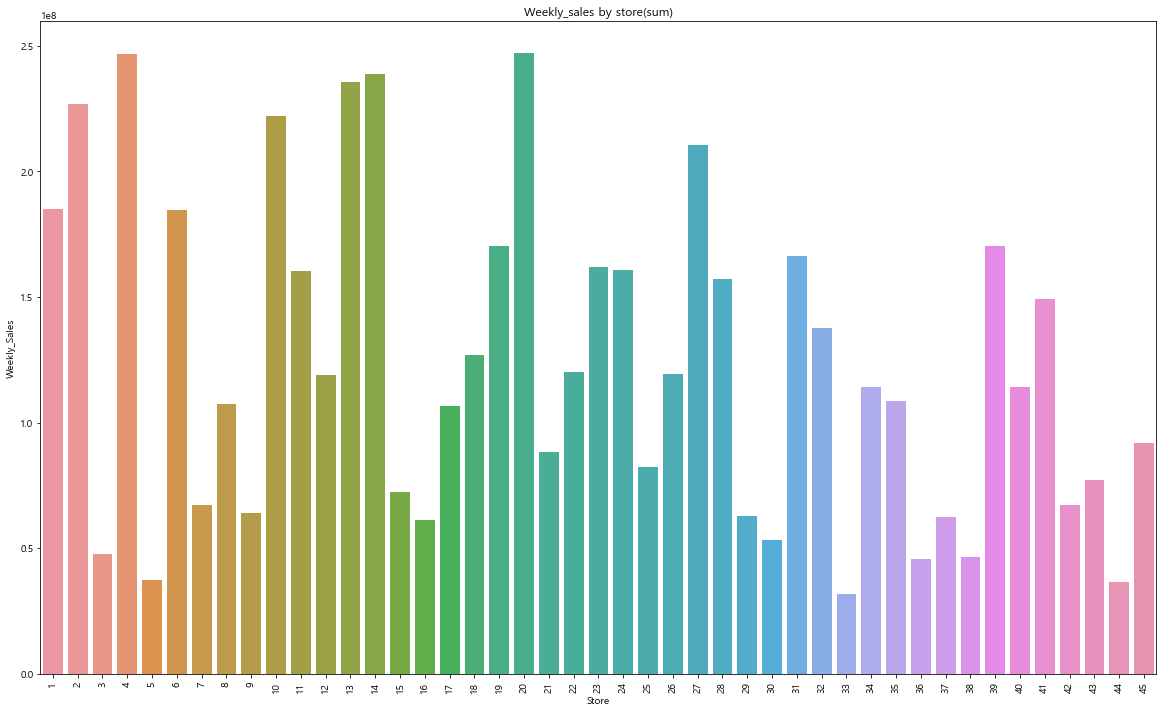

In [39]:
fig = plt.figure(figsize = (20,12))
sns.barplot(x=train_max_store_sum.index, y=train_max_store_sum['Weekly_Sales'], data=train)
plt.title('Weekly_sales by store(sum)')
plt.xticks(rotation=90)
plt.show()

#### 지점별로 매출액의 차이가 크므로 지점별로 모델을 만들어 따로 예측을 해줘야겠다는 생각.

#### 지점별 매출액과 변수들의 상관관계 확인

In [40]:
corr = []
for num in range(1,46):
    co = train[train.Store==num]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['index', 'id','Store','Weekly_Sales'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,46))

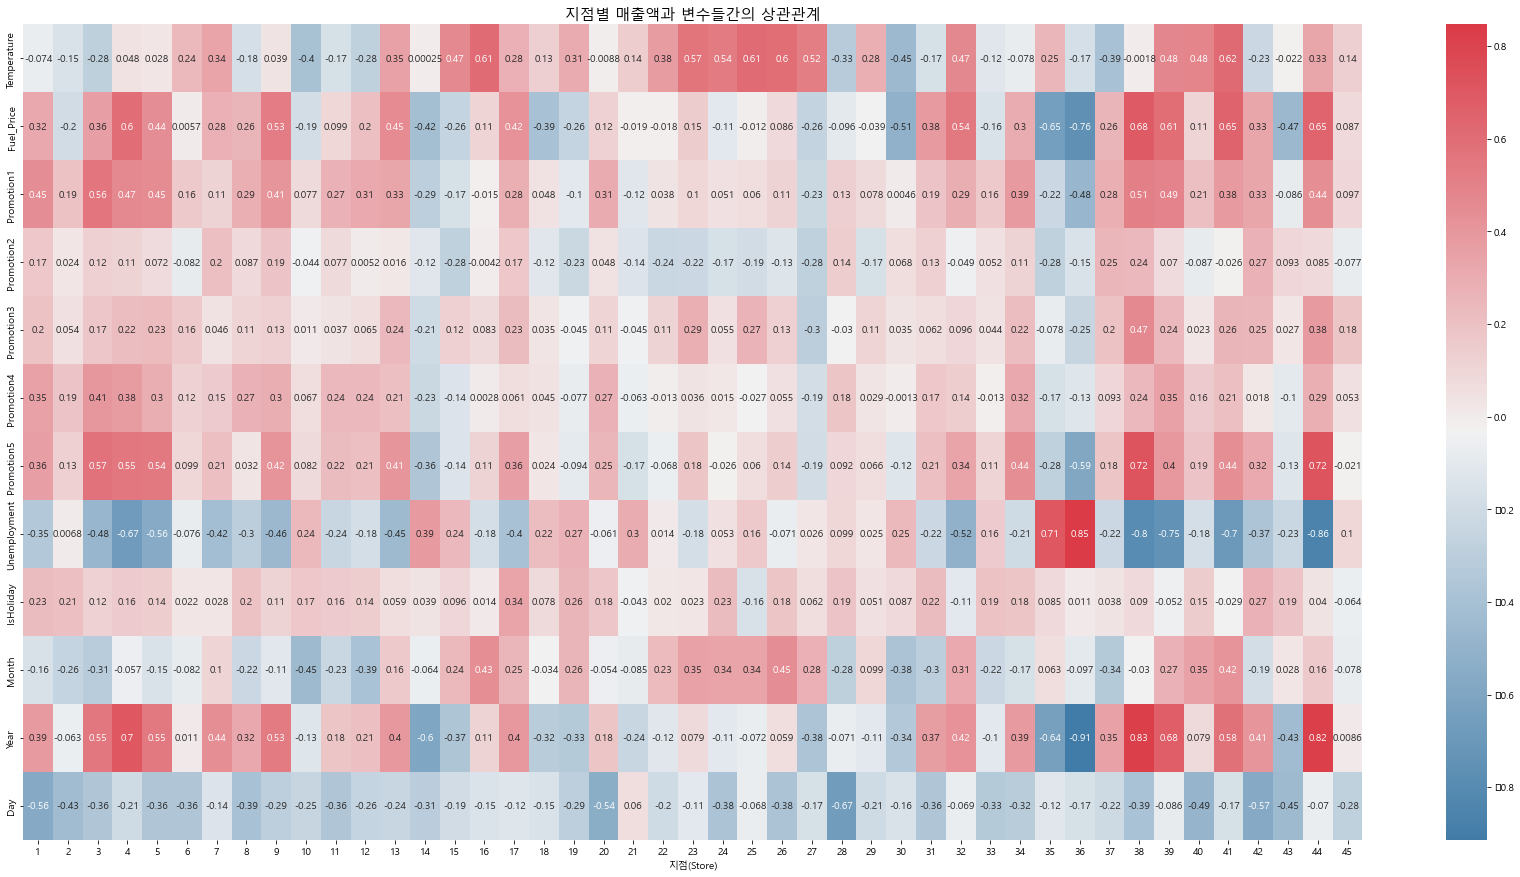

In [41]:
f, ax = plt.subplots(figsize=(30,15))
plt.title("지점별 매출액과 변수들간의 상관관계", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax, annot = True)
plt.xlabel('지점(Store)')
plt.show()

#### 지점별로 변수들과의 상관계수가 다름을 확인할 수 있음
#### Feature Selection의 방법에는 여러가지가 있지만, 아직 학습이 부족해 여러 방법들을 사용해보지 못함
#### 따라서 상관계수를 통한 나름의 Feature Selection을 진행함
#### Store별로 Promotion과의 상관계수 중 0.4 이상인 Feature들만 선택해줌

In [42]:
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

## Feature selection 및 하이퍼 파라미터 설정

결론적으로 Temperature, Fuel_Price, Unemployment 는 모델의 성능 향상에 좋은 영향을 끼치지 못한 것으로 판단함.
모든 Promotion을 Feature에 넣어주는 것 또한 모델의 성능 향상에 좋은 영향을 끼치지 못함.
#### -> 따라서 상관관계를 통해 selct한 Feature들을 각 모델마다 넣어줌

In [43]:
# Store별로 나눠서 모델을 돌렸기 때문에 feature에 Store 있으나 없으나 같으므로 제거.
features = ['IsHoliday','Month','Year','Day']
features_1_3_5 = ['IsHoliday','Month','Year','Day','Promotion1','Promotion3','Promotion5']
features_1_4_5 = ['IsHoliday','Month','Year','Day','Promotion1','Promotion4','Promotion5']
features_1_5 = ['IsHoliday','Month','Year','Day','Promotion1','Promotion5']
features_1 = ['IsHoliday','Month','Year','Day','Promotion1']
features_5 = ['IsHoliday','Month','Year','Day','Promotion5']

# 하이퍼파라미터 설정
model_params = {
  "n_estimators": 3300,
  "max_depth": 3,
  "learning_rate" : 0.01,
}

In [47]:
stop

### 여러가지 모델을 사용해보았지만 CatBoost가 성능이 가장 좋게 나옴 
### 아마 Store별로 모델을 따로 만들어서 예측하다보니 Ordered Boosting 방식을 사용하는 CatBoost의 성능이 좋지 않았나 생각함
### Voting, Stacking등 여러 앙상블 기법 또한 사용해보았지만 CatBoost 단일 모델의 성능이 가장 좋았음

지점별 모델 학습

In [45]:
models = []
for store in range(1,max(train.Store)+1):
  if (store == 38):
    train_store = train[train.Store==store]
    model = CatBoostRegressor(**model_params)
    model.fit(train_store[features_1_3_5], train_store.Weekly_Sales)
    models.append(model)
    
  elif (store == 3):
    train_store = train[train.Store==store]
    model = CatBoostRegressor(**model_params)
    model.fit(train_store[features_1_4_5], train_store.Weekly_Sales)
    models.append(model)
    
  elif (store == 4 or store == 5 or store == 9 or store == 44):
    train_store = train[train.Store==store]
    model = CatBoostRegressor(**model_params)
    model.fit(train_store[features_1_5], train_store.Weekly_Sales)
    models.append(model)
    
  elif (store == 1 or store == 39):
    train_store = train[train.Store==store]
    model = CatBoostRegressor(**model_params)
    model.fit(train_store[features_1], train_store.Weekly_Sales)
    models.append(model)
    
  elif (store == 13 or store == 34 or store == 41):
    train_store = train[train.Store==store]
    model = CatBoostRegressor(**model_params)
    model.fit(train_store[features_5], train_store.Weekly_Sales)
    models.append(model)
    
  else:
    train_store = train[train.Store==store]
    model = CatBoostRegressor(**model_params)
    model.fit(train_store[features], train_store.Weekly_Sales)
    models.append(model)

지점별 모델 예측

In [ ]:
pred = []
for store in range(1, max(test.Store)+1):
    if (store == 38):
      test_store = test[test.Store==store]
      y_pred = models[store-1].predict(test_store[features_1_3_5])
      pred += y_pred.tolist()
      
    elif (store == 3):
      test_store = test[test.Store==store]
      y_pred = models[store-1].predict(test_store[features_1_4_5])
      pred += y_pred.tolist()
      
    elif (store == 4 or store == 5 or store == 9 or store == 44):
      test_store = test[test.Store==store]
      y_pred = models[store-1].predict(test_store[features_1_5])
      pred += y_pred.tolist()
      
    elif (store == 1 or store == 39 ):
      test_store = test[test.Store==store]
      y_pred = models[store-1].predict(test_store[features_1])
      pred += y_pred.tolist()
      
    elif (store == 13 or store == 34 or store == 41):
      test_store = test[test.Store==store]
      y_pred = models[store-1].predict(test_store[features_5])
      pred += y_pred.tolist()
    
    else:
      test_store = test[test.Store==store]
      y_pred = models[store-1].predict(test_store[features])
      pred += y_pred.tolist()

결과물 제출

In [ ]:
submission['Weekly_Sales'] = pred
submission.to_csv('vacation_submission_final.csv', index=False)
submission

,id,Weekly_Sales
0,1,1690753.36
1,2,1549696.73
2,3,1524766.80
3,4,1461611.18
4,5,1920476.18
...,...,...
175,176,351333.12
176,177,769814.63
177,178,734785.37
178,179,736695.64
